In [2]:
import numpy as np
import pandas as pd
import glob
import os.path
import datetime
import os

In [3]:
def read_plt(plt_file):
    points = pd.read_csv(plt_file, skiprows=6, header=None)

    # for clarity rename columns
    points.rename(inplace=True, columns={0: 'lat', 1: 'lon', 3: 'alt', 5: 'day', 6: 'hour'})
    
    date_format = '%Y-%m-%d %H:%M:%S'
    points['time'] = pd.to_datetime(points['day'] + ' ' + points['hour'], format=date_format)

    # remove unused columns
    points.drop(inplace=True, columns=[2, 4, 'day', 'hour'])
    last_lat = points.iloc[-1]['lat']
    last_lon = points.iloc[-1]['lon']
    points['destination'] = [(last_lat, last_lon)] * len(points)
    points = points.drop(points.index[-1])
    return points

plt_file = "/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
df_plt = read_plt(plt_file)
df_plt

,lat,lon,alt,time,destination
0,39.984702,116.318417,492,2008-10-23 02:53:04,"(40.009328, 116.320887)"
1,39.984683,116.318450,492,2008-10-23 02:53:10,"(40.009328, 116.320887)"
2,39.984686,116.318417,492,2008-10-23 02:53:15,"(40.009328, 116.320887)"
3,39.984688,116.318385,492,2008-10-23 02:53:20,"(40.009328, 116.320887)"
4,39.984655,116.318263,492,2008-10-23 02:53:25,"(40.009328, 116.320887)"
...,...,...,...,...,...
902,40.009064,116.321326,90,2008-10-23 11:10:47,"(40.009328, 116.320887)"
903,40.009172,116.321211,88,2008-10-23 11:10:52,"(40.009328, 116.320887)"
904,40.009204,116.321130,86,2008-10-23 11:10:57,"(40.009328, 116.320887)"
905,40.009243,116.321050,85,2008-10-23 11:11:02,"(40.009328, 116.320887)"


In [4]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_ids = {s : i + 1 for i, s in enumerate(mode_names)} #walk: 1, ..., taxi: 11

def read_labels(labels_file):
    labels = pd.read_csv(labels_file, skiprows=1, header=None, sep='\s+')
    labels['start_time'] = pd.to_datetime(labels[0] + ' ' + labels[1])
    labels['end_time'] = pd.to_datetime(labels[2] + ' ' + labels[3])
    labels.rename(inplace=True, columns = {4: 'label'})

    labels.drop(inplace=True, columns=[0,1,2,3])
    labels['label'] = [mode_ids[i] for i in labels['label']]

    return labels

labels_file = "/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data/065/labels.txt"
labels = read_labels(labels_file)
labels

,label,start_time,end_time
0,1,2011-08-24 13:51:21,2011-08-24 13:52:44
1,2,2011-08-25 00:36:03,2011-08-25 00:58:25
2,2,2011-08-25 14:44:57,2011-08-25 14:58:30
3,1,2011-08-26 01:01:58,2011-08-26 01:24:01
4,1,2011-08-28 01:11:21,2011-08-28 07:20:04
...,...,...,...
201,1,2012-01-07 12:01:34,2012-01-07 12:04:37
202,3,2012-01-07 12:04:38,2012-01-07 12:11:09
203,1,2012-01-07 12:11:10,2012-01-07 12:24:10
204,11,2012-01-08 05:30:59,2012-01-08 05:59:00


In [5]:
def apply_labels(points, labels):
    indices = labels['start_time'].searchsorted(points['time'], side='right') - 1    
    #indices:  chỉ ra khoảng thời gian nào trong labels dataframe mà point có thể thuộc vào
    
    no_label_condition = (indices < 0) | (points['time'].values >= labels['end_time'].iloc[indices].values)
    points['mode_of_transport'] = labels['label'].iloc[indices].values
    points.loc[no_label_condition, 'mode_of_transport'] = 0

In [6]:
def read_user(user_folder):
    labels = None

    plt_files = glob.glob(os.path.join(user_folder, 'Trajectory', '*.plt'))
    df = pd.concat([read_plt(f) for f in plt_files])

    labels_file = os.path.join(user_folder, 'labels.txt')
    if os.path.exists(labels_file):
        labels = read_labels(labels_file)
        apply_labels(df, labels)
    else:
        df['mode_of_transport'] = 0

    return df

user_folder = "/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data/065"
df_user = read_user(user_folder)
df_user

,lat,lon,alt,time,destination,mode_of_transport
0,39.973048,116.331114,492.0,2009-08-04 13:59:00,"(39.979361, 116.332605)",0
1,39.974279,116.331031,383.0,2009-08-04 13:59:05,"(39.979361, 116.332605)",0
2,39.974275,116.331079,317.0,2009-08-04 14:04:50,"(39.979361, 116.332605)",0
3,39.974735,116.331142,308.0,2009-08-04 14:04:55,"(39.979361, 116.332605)",0
4,39.974910,116.331073,297.0,2009-08-04 14:05:00,"(39.979361, 116.332605)",0
...,...,...,...,...,...,...
2666,39.977648,116.304265,0.0,2011-10-27 00:56:53,"(39.9775716666667, 116.304226666667)",2
2667,39.977645,116.304247,0.0,2011-10-27 00:56:54,"(39.9775716666667, 116.304226666667)",2
2668,39.977645,116.304245,0.0,2011-10-27 00:56:54,"(39.9775716666667, 116.304226666667)",2
2669,39.977645,116.304248,0.0,2011-10-27 00:56:54,"(39.9775716666667, 116.304226666667)",2


In [7]:
def correct_label(df_user):
    df_user = df_user[df_user['mode_of_transport'] != 0].copy()
    if len(df_user) != 0:
        df_user['mode_of_transport'] = df_user['mode_of_transport'] - 1
    return df_user
df_user = correct_label(df_user)
df_user

,lat,lon,alt,time,destination,mode_of_transport
0,39.978887,116.332237,0.0,2011-08-24 13:51:21,"(39.9776133333333, 116.33241)",0
1,39.978903,116.332268,0.0,2011-08-24 13:51:21,"(39.9776133333333, 116.33241)",0
2,39.978683,116.332422,0.0,2011-08-24 13:51:40,"(39.9776133333333, 116.33241)",0
3,39.978650,116.332470,0.0,2011-08-24 13:51:41,"(39.9776133333333, 116.33241)",0
4,39.978645,116.332475,0.0,2011-08-24 13:51:41,"(39.9776133333333, 116.33241)",0
...,...,...,...,...,...,...
2665,39.977648,116.304267,0.0,2011-10-27 00:56:53,"(39.9775716666667, 116.304226666667)",1
2666,39.977648,116.304265,0.0,2011-10-27 00:56:53,"(39.9775716666667, 116.304226666667)",1
2667,39.977645,116.304247,0.0,2011-10-27 00:56:54,"(39.9775716666667, 116.304226666667)",1
2668,39.977645,116.304245,0.0,2011-10-27 00:56:54,"(39.9775716666667, 116.304226666667)",1


In [8]:
def remove_duplication(df_user):
    df_user = df_user.drop_duplicates(subset=['time'], keep='first')
    return df_user

df_user = remove_duplication(df_user)

In [9]:
def segment_user_trajectory(user_folder, df_user, threshold_timediff = (60*2)):
    
    user_name = user_folder.split('/')[-1]
    tid = 0
    modified_groups = []
    
    for segmentor, group in df_user.groupby('mode_of_transport'):
        group = group.sort_values(by = 'time', ascending = True)
        group.index = range(len(group))

        group['tid'] = 'tid'
        group['time_diff'] = group['time'].diff().dt.total_seconds()
        group['time_diff'] = group['time_diff'].fillna(0)
#         print(group)

        indices = list((group[group['time_diff'] > threshold_timediff]).index)
        
        
        if indices:
            if indices[-1] <= len(group)-1:
                indices.append(len(group))
#             print(indices)
            
            start = 0
            for index in indices:
                                            
                group.loc[start:(index-1), 'tid'] = f'{user_name}_{tid}'
                                            
#                 print("---------------------------------------")
#                 print("start", start)
#                 print("index", index-1)                
#                 print(group.loc[start:(index-1)])
#                 print("---------------------------------------")
                                            
                start = index
                tid = tid + 1
        else:
#             print(indices)
            group['tid'] = f'{user_name}_{tid}'
            tid = tid + 1
            
            
        modified_groups.append(group)
        
    df_modified = pd.concat(modified_groups)
    
    return df_modified

df_user_segment = segment_user_trajectory(user_folder, df_user)

In [10]:
# Calculate distance between consecutive coordinates
def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    R = 6371  # Radius of the Earth in kilometers

    # Convert coordinates to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Haversine formula to calculate surface distance
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    surface_distance = R * c * 1000 # in meter

    # Calculate altitude difference
    dalt = alt2 - alt1  # in kilometers (assuming altitudes are provided in kilometers)

    # Combine surface distance and altitude difference using Pythagorean theorem
    distance = np.sqrt(surface_distance ** 2 + dalt ** 2) 

    return distance

In [23]:
def create_attribute(df_user):
    
    
        
    df_user['alt'] = df_user['alt'] * 0.3048  # Convert altitude from feet to meters
    df_user['time_diff'] = df_user['time'].diff().dt.total_seconds()
    df_user['distance'] = calculate_distance(df_user['lat'].shift().values, df_user['lon'].shift().values, df_user['alt'].shift().values, 
                                            df_user['lat'].values, df_user['lon'].values, df_user['alt'].values)
        
    df_user['speed'] = df_user['distance'] / df_user['time_diff']
    df_user.fillna(0, inplace = True)
    df_user['acceleration'] = df_user['speed'].diff() / df_user['time_diff']
        
    df_user.fillna(0, inplace = True)

        
   
    
    return df_user

df_user_engineering = create_attribute(df_user_segment)
df_user_engineering

,lat,lon,alt,time,destination,mode_of_transport,tid,time_diff,distance,speed,acceleration
0,39.978887,116.332237,0.0,2011-08-24 13:51:21,"(39.9776133333333, 116.33241)",0,065_0,0.0,0.000000,0.000000,0.000000
1,39.978683,116.332422,0.0,2011-08-24 13:51:40,"(39.9776133333333, 116.33241)",0,065_0,19.0,27.562210,1.450643,0.076350
2,39.978650,116.332470,0.0,2011-08-24 13:51:41,"(39.9776133333333, 116.33241)",0,065_0,1.0,5.540648,5.540648,4.090005
3,39.978628,116.332495,0.0,2011-08-24 13:51:42,"(39.9776133333333, 116.33241)",0,065_0,1.0,3.215897,3.215897,-2.324751
4,39.978605,116.332522,0.0,2011-08-24 13:51:43,"(39.9776133333333, 116.33241)",0,065_0,1.0,3.448841,3.448841,0.232944
...,...,...,...,...,...,...,...,...,...,...,...
8128,39.954012,116.355103,0.0,2011-10-23 05:37:26,"(39.9536083333333, 116.354935)",10,065_282,1.0,7.033574,7.033574,-0.957916
8129,39.953965,116.355130,0.0,2011-10-23 05:37:27,"(39.9536083333333, 116.354935)",10,065_282,1.0,5.665092,5.665092,-1.368482
8130,39.953933,116.355147,0.0,2011-10-23 05:37:28,"(39.9536083333333, 116.354935)",10,065_282,1.0,3.796952,3.796952,-1.868141
8131,39.953893,116.355172,0.0,2011-10-23 05:37:29,"(39.9536083333333, 116.354935)",10,065_282,1.0,4.931918,4.931918,1.134967


In [26]:
def read_all_users(folder):
    subfolders = os.listdir(folder)
    dfs = []
    for i, sf in enumerate(subfolders):
        print('[%d/%d] processing user %s' % (i + 1, len(subfolders), sf))
        user_folder = os.path.join(folder,sf)
        df_user = read_user(user_folder)
        df_user = correct_label(df_user)
        if len(df_user) != 0:
            df_user = remove_duplication(df_user)
            df_user_segment = segment_user_trajectory(user_folder, df_user)
            df_user_all=create_attribute(df_user_segment)
            dfs.append(df_user_all)
                
    return pd.concat(dfs)

df = read_all_users('/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data')

[1/182] processing user 000
[2/182] processing user 001
[3/182] processing user 002
[4/182] processing user 003
[5/182] processing user 004
[6/182] processing user 005
[7/182] processing user 006
[8/182] processing user 007
[9/182] processing user 008
[10/182] processing user 009
[11/182] processing user 010
[12/182] processing user 011
[13/182] processing user 012
[14/182] processing user 013
[15/182] processing user 014
[16/182] processing user 015
[17/182] processing user 016
[18/182] processing user 017
[19/182] processing user 018
[20/182] processing user 019
[21/182] processing user 020
[22/182] processing user 021
[23/182] processing user 022
[24/182] processing user 023
[25/182] processing user 024
[26/182] processing user 025
[27/182] processing user 026
[28/182] processing user 027
[29/182] processing user 028
[30/182] processing user 029
[31/182] processing user 030
[32/182] processing user 031
[33/182] processing user 032
[34/182] processing user 033
[35/182] processing use

In [27]:
df

,lat,lon,alt,time,destination,mode_of_transport,tid,time_diff,distance,speed,acceleration
0,41.169583,80.262702,-236.8296,2008-04-01 01:00:22,"(39.473507, 76.000835)",0,Data\010_0,0.0,0.000000,0.000000,0.000000
1,41.169568,80.263422,-236.8296,2008-04-01 01:01:22,"(39.473507, 76.000835)",0,Data\010_0,60.0,60.289669,1.004828,0.016747
2,41.169568,80.263422,-236.8296,2008-04-01 01:02:19,"(39.473507, 76.000835)",0,Data\010_0,57.0,0.000000,0.000000,-0.017629
3,41.169568,80.263422,-236.8296,2008-04-01 01:02:21,"(39.473507, 76.000835)",0,Data\010_0,2.0,0.000000,0.000000,0.000000
4,41.169175,80.263630,-236.8296,2008-04-01 01:03:20,"(39.473507, 76.000835)",0,Data\010_0,59.0,47.040171,0.797291,0.013513
...,...,...,...,...,...,...,...,...,...,...,...
1791,39.992520,116.326051,55.7784,2008-11-07 10:21:56,"(40.08931, 116.298673)",10,Data\179_478,2.0,6.307061,3.153531,-0.066734
1792,39.992491,116.325979,55.1688,2008-11-07 10:21:58,"(40.08931, 116.298673)",10,Data\179_478,2.0,6.956413,3.478206,0.162338
1793,39.992405,116.325812,55.1688,2008-11-07 10:22:00,"(40.08931, 116.298673)",10,Data\179_478,2.0,17.141901,8.570950,2.546372
1794,39.992402,116.325784,55.1688,2008-11-07 10:22:02,"(40.08931, 116.298673)",10,Data\179_478,2.0,2.408525,1.204263,-3.683344


In [28]:
df.to_csv('/Geolife Trajectories 1.3/geolife.csv', index=False)

In [32]:
df1=df.drop(['tid','destination'],axis=1)

In [33]:
df1

,lat,lon,alt,time,mode_of_transport,time_diff,distance,speed,acceleration
0,41.169583,80.262702,-236.8296,2008-04-01 01:00:22,0,0.0,0.000000,0.000000,0.000000
1,41.169568,80.263422,-236.8296,2008-04-01 01:01:22,0,60.0,60.289669,1.004828,0.016747
2,41.169568,80.263422,-236.8296,2008-04-01 01:02:19,0,57.0,0.000000,0.000000,-0.017629
3,41.169568,80.263422,-236.8296,2008-04-01 01:02:21,0,2.0,0.000000,0.000000,0.000000
4,41.169175,80.263630,-236.8296,2008-04-01 01:03:20,0,59.0,47.040171,0.797291,0.013513
...,...,...,...,...,...,...,...,...,...
1791,39.992520,116.326051,55.7784,2008-11-07 10:21:56,10,2.0,6.307061,3.153531,-0.066734
1792,39.992491,116.325979,55.1688,2008-11-07 10:21:58,10,2.0,6.956413,3.478206,0.162338
1793,39.992405,116.325812,55.1688,2008-11-07 10:22:00,10,2.0,17.141901,8.570950,2.546372
1794,39.992402,116.325784,55.1688,2008-11-07 10:22:02,10,2.0,2.408525,1.204263,-3.683344


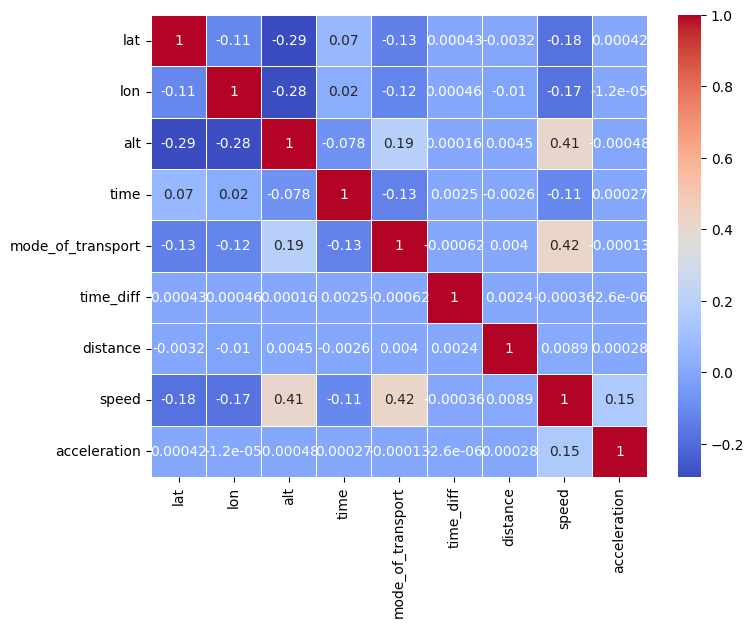

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# Step 1: Compute correlation matrix
correlation_matrix = df1.corr()

# Step 2: Plot heatmap
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Show plot
plt.show()

In [2]:
import pandas as pd
data=pd.read_csv('/Geolife Trajectories 1.3/geolife.csv')

In [38]:
data.info

<bound method DataFrame.info of                lat         lon       alt                 time  \
0        41.169583   80.262702 -236.8296  2008-04-01 01:00:22   
1        41.169568   80.263422 -236.8296  2008-04-01 01:01:22   
2        41.169568   80.263422 -236.8296  2008-04-01 01:02:19   
3        41.169568   80.263422 -236.8296  2008-04-01 01:02:21   
4        41.169175   80.263630 -236.8296  2008-04-01 01:03:20   
...            ...         ...       ...                  ...   
4852153  39.992520  116.326051   55.7784  2008-11-07 10:21:56   
4852154  39.992491  116.325979   55.1688  2008-11-07 10:21:58   
4852155  39.992405  116.325812   55.1688  2008-11-07 10:22:00   
4852156  39.992402  116.325784   55.1688  2008-11-07 10:22:02   
4852157  39.992363  116.325729   54.8640  2008-11-07 10:22:04   

                    destination  mode_of_transport           tid  time_diff  \
0        (39.473507, 76.000835)                  0    Data\010_0        0.0   
1        (39.473507, 76.00083